# Clustering 

*Based on materials by Brandon Rose, Jacob Eisenstein, and Eun Seo Jo et al.*

Last week, we learned about classification, which assumes we have a test set of data that we have already categorized: in our case, we categorized by gender. When we run models with labeled data, we call it _supervised learning_.

But what happens when we don't have labeled data? Is it possible to learn anything? 

This scenario is known as *unsupervised learning*, and we will see that it is very possible to learn about the underlying structure of unlabeled observations. 

## An example

Here’s a scenario: 

Suppose you scrape thousands of news articles. And suppose you want to organize, or cluster, those documents by their prevalence of language about hurricanes vs elections. You could choose a group of words relate to hurricanes and make the x-axis the frequency with which those words appear in the documents. You could do the same for words related to elections on the y-axis. We might imagine the articles clustering into four groups: one for documents that are largely about a hurricane, another for documents largely about a election, a third for documents about neither, and a fourth for documents, however unlikely, about both.

These clusters represent an underlying structure of the data. But it's still supervised, because we've labeled words as belonging to categories and used them to organize documents.

Unsupervised learning applies the same basic idea, but in a high-dimensional space with one dimension for every word. As such, the space can’t be visualized. But the goal is the same as in two-dimensions: identify an underlying structure of the observed data, such that documents cluster, and each cluster is internally coherent. 

**Clustering algorithms** are capable of finding such structure automatically.

## Enter k-means clustering 

Clustering algorithms assign each data point—for us, each document—to a discrete cluster. One of the best known clustering algorithms is k-means, an iterative algorithm that maintains a cluster assignment for each instance, and a central ("mean") location for each cluster. K-means iterates between updates to the assignments and the centers:

1. each instance is placed in the cluster with the closest center;

2. each center is recomputed as the average over points in the cluster.

Here is a video that illustrates this process very clearly:
[https://www.youtube.com/watch?v=R2e3Ls9H_fc](https://www.youtube.com/watch?v=R2e3Ls9H_fc)

**NOTE:** An important property of k-means is that the converged solution depends on the initialization, and a better clustering can sometimes be found simply by re-running the algorithm from a different random starting point.

## Let's get to it! ##

In this example, we're going to use k-means clustering to identify the latent structures within the synopses of the top 100 films of all time (per an IMDB list), a corpus created by Brandon Rose. See [the original post](http://www.brandonrose.org/top100) for a more detailed discussion on the corpus.

Let's start with the imports. They include old friends: re, BeautifulSoup, nltk, pandas, sklearn, a veritable journey through our semester:

In [1]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup 
import re 
from sklearn import feature_extraction

## Corpus Pre-Proccesing ##

Here we go again. Let's pre-process our corpus. 

In [2]:
# import four files that each map to each other: titles, links, wikipedia synopses, and associated dgenres

# first, the list of film titles, in order of top-ness
titles = open('../corpora/imdb/title_list.txt').read().split('\n')

# ensures that only the top 100 titles are read in
titles = titles[:100]

# a list of URLS to each film on IMDB, in the same order as the first
links = open('../corpora/imdb/link_list_imdb.txt').read().split('\n')
links = links[:100]

# a list of synopses of each film, in the same order as both files above, with "BREAKS HERE" separating each entry
synopses_wiki = open('../corpora/imdb/synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_clean_wiki = []

for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    # strips html formatting and converts to unicode
    synopses_clean_wiki.append(text)

synopses_wiki = synopses_clean_wiki

# now the list of associated genres, one film per line, in the same order as above
genres = open('../corpora/imdb/genres_list.txt').read().split('\n')
genres = genres[:100]

print(str(len(titles)) + ' titles')
print(str(len(links)) + ' links')
print(str(len(synopses_wiki)) + ' synopses')
print(str(len(genres)) + ' genres')

100 titles
100 links
100 synopses
100 genres


Let's see what movies we have and their genres

In [3]:
for x in range(99):
    print(titles[x], genres[x])

The Godfather [u' Crime', u' Drama']
The Shawshank Redemption [u' Crime', u' Drama']
Schindler's List [u' Biography', u' Drama', u' History']
Raging Bull [u' Biography', u' Drama', u' Sport']
Casablanca [u' Drama', u' Romance', u' War']
One Flew Over the Cuckoo's Nest [u' Drama']
Gone with the Wind [u' Drama', u' Romance', u' War']
Citizen Kane [u' Drama', u' Mystery']
The Wizard of Oz [u' Adventure', u' Family', u' Fantasy', u' Musical']
Titanic [u' Drama', u' Romance']
Lawrence of Arabia [u' Adventure', u' Biography', u' Drama', u' History', u' War']
The Godfather: Part II [u' Crime', u' Drama']
Psycho [u' Horror', u' Mystery', u' Thriller']
Sunset Blvd. [u' Drama', u' Film-Noir']
Vertigo [u' Mystery', u' Romance', u' Thriller']
On the Waterfront [u' Crime', u' Drama']
Forrest Gump [u' Drama', u' Romance']
The Sound of Music [u' Biography', u' Drama', u' Family', u' Musical', u' Romance']
West Side Story [u' Crime', u' Drama', u' Musical', u' Romance', u' Thriller']
Star Wars [u' Act

Let's check out the first synopsis

In [4]:
print(synopses_wiki[0])

 Plot  [edit]  [  [  edit  edit  ]  ]  
  On the day of his only daughter's wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito's youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the sprawling reception. Vito's godson Johnny Fontane, a popular singer, pleads for help in securing a coveted movie role, so Vito dispatches his consigliere, Tom Hagen, to Los Angeles to influence the abrasive studio head, Jack Woltz. Woltz is unmoved until the morning he wakes up in bed with the severed head of his prized stallion.  On the day of his only daughter's wedding,   Vito Corleone  Vito Corleone   hears requests in his role as the Godfather, the   Don  Don   of a New York crime family. Vito's youngest son,   Michael  Michael  , in a   Marine Corps  Marine Corps   uniform, introduces his girlfriend,   Kay Adams  Kay Adams  , to his family at the sprawling reception. Vito's godson   Johnny

In [5]:
# now let's get the imdb synopses as well

synopses_imdb = open('../corpora/imdb/synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

synopses_clean_imdb = []

for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_imdb.append(text)

synopses_imdb = synopses_clean_imdb

In [6]:
# make a list with the two sets of synopses—from imdb and wikipedia

synopses = []

for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)

# see what one looks like
print(synopses[0])

 Plot  [edit]  [  [  edit  edit  ]  ]  
  On the day of his only daughter's wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito's youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the sprawling reception. Vito's godson Johnny Fontane, a popular singer, pleads for help in securing a coveted movie role, so Vito dispatches his consigliere, Tom Hagen, to Los Angeles to influence the abrasive studio head, Jack Woltz. Woltz is unmoved until the morning he wakes up in bed with the severed head of his prized stallion.  On the day of his only daughter's wedding,   Vito Corleone  Vito Corleone   hears requests in his role as the Godfather, the   Don  Don   of a New York crime family. Vito's youngest son,   Michael  Michael  , in a   Marine Corps  Marine Corps   uniform, introduces his girlfriend,   Kay Adams  Kay Adams  , to his family at the sprawling reception. Vito's godson   Johnny

### For document clustering, some people like to stem first ###

In [10]:
import sys
# !{sys.executable} -m pip install textblob # an alternative to spaCy
from textblob import TextBlob

def textblob_tokenizer(str_input):
    blob = TextBlob(str_input.lower())
    tokens = blob.words
    words = [token.stem() for token in tokens]
    return words

## Now tf-idf

Before we can cluster our documents—the movie synopses—we need to prepare them as vectors. We're going to prepare them as *tf-idf* vectors because they provide more effective clusters than other ways of counting words, for example raw word counts.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, 
                                    ngram_range=(1,3), min_df=.2, max_df=0.8) #note new params

tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_vectorizer_vectors.shape)

(100, 496)


We have 100 vectors, one for each synopsis, and each vector has values for 496 features. What are those features? Let's find out.

In [8]:
# get our feature names for future reference 
# terms = tfidf_vectorizer.get_feature_names()
terms = tfidf_vectorizer.get_feature_names_out()
terms

array(['000', 'able', 'accepts', 'accident', 'act', 'action', 'actually',
       'admits', 'ago', 'agrees', 'air', 'alive', 'allow', 'allows',
       'american', 'angrily', 'angry', 'apartment', 'apparently',
       'appears', 'approaches', 'area', 'army', 'arrive', 'arrives',
       'ask', 'asking', 'asks', 'attack', 'attacks', 'attempt',
       'attempts', 'attention', 'audience', 'avoid', 'away', 'bad', 'bar',
       'battle', 'bed', 'begin', 'beginning', 'begins', 'begs', 'believe',
       'believes', 'believing', 'best', 'better', 'big', 'black', 'board',
       'body', 'boss', 'boy', 'break', 'breaks', 'brief', 'bring',
       'brings', 'broken', 'brother', 'building', 'business', 'buy',
       'called', 'calls', 'captain', 'car', 'care', 'career', 'carrying',
       'catches', 'causes', 'causing', 'chance', 'change', 'child',
       'children', 'city', 'claims', 'close', 'come', 'comes', 'coming',
       'company', 'confesses', 'confronts', 'continue', 'continues',
       'contr

In [9]:
# get the first vector out (for the first synopsis) just to see what it looks like 
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0]

# place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=terms, columns=["tfidf"])

df.sort_values(by=["tfidf"],ascending=False).head(10)

,tfidf
don,0.637356
family,0.398226
son,0.202580
business,0.196110
meeting,0.183853
father,0.175291
killed,0.124536
murder,0.111914
hospital,0.105659
men,0.093675


This is the vector for **The Godfather**. It scores high on 'don', 'family', and 'son'.

## And on to the k-means clustering

Using our tf-idf vectors, we can now run the k-means clustering algorithm. Remember that k-means initializes with a pre-determined number of clusters. Let's choose 5. 

**NOTE:** One of the metrics commonly used to compare results across different values of k is the mean distance between data points and their cluster centroid. Since increasing the number of clusters will always reduce the distance to data points, increasing k will always decrease this metric, to the extreme of reaching zero when k is the same as the number of data points. Thus, this metric cannot be used as the sole target. Instead, mean distance to the centroid as a function of k is plotted and the "elbow point," where the rate of decrease sharply shifts, can be used to roughly determine the ideal value for k.

A number of other techniques exist for validating k, but that's the most common one. 

In any case, back to our clusters:

In [10]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters, n_init=10) # default is also 10, but good to know 

km.fit(tfidf_vectorizer_vectors)

# km.labels_ gives you the cluster assignments
clusters = km.labels_.tolist()

In [11]:
# dump our clusters into a dataframe
films = { 'title': titles, 'idx': list(range(100)), 'synopsis': synopses, 'cluster': clusters, 'genre': genres }

film_df = pd.DataFrame(films, columns = ['title', 'idx', 'cluster', 'genre'])

film_df

,title,idx,cluster,genre
0,The Godfather,0,0,"[u' Crime', u' Drama']"
1,The Shawshank Redemption,1,1,"[u' Crime', u' Drama']"
2,Schindler's List,2,4,"[u' Biography', u' Drama', u' History']"
3,Raging Bull,3,0,"[u' Biography', u' Drama', u' Sport']"
4,Casablanca,4,1,"[u' Drama', u' Romance', u' War']"
...,...,...,...,...
95,Rebel Without a Cause,95,1,[u' Drama']
96,Rear Window,96,1,"[u' Mystery', u' Thriller']"
97,The Third Man,97,1,"[u' Film-Noir', u' Mystery', u' Thriller']"
98,North by Northwest,98,1,"[u' Mystery', u' Thriller']"


In [12]:
# find out how many films are in each cluster
film_df['cluster'].value_counts()

1    56
4    19
0    12
3     7
2     6
Name: cluster, dtype: int64

In [13]:
# find the top terms per cluster

# this orders by the distance of each term from the center
# (cluster_centers_ returns an array of [n_clusters, n_features] )
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster " + str(i) + " top words: ")
    top_terms = ""
   
    for ind in order_centroids[i, :10]:
        top_terms += terms[ind] + ", "
  
    print(top_terms)

Cluster 0 top words: 
don, father, son, family, brother, fight, robert, war, says, film, 
Cluster 1 top words: 
police, car, apartment, home, father, mother, house, new, night, away, 
Cluster 2 top words: 
george, marry, family, john, join, james, father, play, house, act, 
Cluster 3 top words: 
mr, captain, water, day, return, attempts, officer, children, tries, takes, 
Cluster 4 top words: 
army, soldiers, war, men, killed, general, battle, group, attack, wounded, 


In [14]:
# find all films in each cluster    
for i in range(num_clusters):  
    print("Titles in cluster " + str(i) + ": ")
    cluster_titles = ""

    # create new df of only the specific cluster
    # remember boolean selection! 
    cluster_df = film_df[ film_df["cluster"] == i ]
 
    # create series of titles assoc w/ that cluster 
    for title in cluster_df['title']: 
        cluster_titles += title + ", "

    print(cluster_titles + "\n")

Titles in cluster 0: 
The Godfather, Raging Bull, Gone with the Wind, The Godfather: Part II, Singin' in the Rain, Amadeus, Gladiator, To Kill a Mockingbird, Braveheart, City Lights, Giant, Shane, 

Titles in cluster 1: 
The Shawshank Redemption, Casablanca, One Flew Over the Cuckoo's Nest, Citizen Kane, The Wizard of Oz, Titanic, Psycho, Sunset Blvd., Vertigo, On the Waterfront, Forrest Gump, West Side Story, Star Wars, E.T. the Extra-Terrestrial, 2001: A Space Odyssey, The Silence of the Lambs, Chinatown, Some Like It Hot, 12 Angry Men, Gandhi, Unforgiven, Rocky, A Streetcar Named Desire, An American in Paris, The Best Years of Our Lives, My Fair Lady, Ben-Hur, Doctor Zhivago, The Good, the Bad and the Ugly, The Apartment, High Noon, The Pianist, Goodfellas, The Exorcist, The French Connection, It Happened One Night, Midnight Cowboy, Rain Man, Annie Hall, Out of Africa, Good Will Hunting, Terms of Endearment, Fargo, The Green Mile, Close Encounters of the Third Kind, The Graduate, Am

In [15]:
# Find the top 10 films in each cluster    
for i in range(num_clusters):  
    
    # returns array w/ distances to the centroid i 
    dist = km.transform(tfidf_vectorizer_vectors)[:, i] 
    
    # return indices for top 10 for that cluster 
    idxs = np.argsort(dist)[::][:10] 
    
    print("Top 10 films in cluster " + str(i) + ": ")
    cluster_top_films = ""

    # look up film title by index
    for idx in idxs: 
        cluster_top_films += film_df.loc[idx,'title'] + ", "
        
    print(cluster_top_films + "\n")

Top 10 films in cluster 0: 
The Godfather: Part II, The Godfather, Gone with the Wind, Braveheart, Gladiator, To Kill a Mockingbird, On the Waterfront, Giant, Amadeus, Raging Bull, 

Top 10 films in cluster 1: 
North by Northwest, The Third Man, Psycho, Gone with the Wind, Fargo, Doctor Zhivago, The French Connection, On the Waterfront, Pulp Fiction, Rocky, 

Top 10 films in cluster 2: 
It's a Wonderful Life, A Place in the Sun, The King's Speech, Tootsie, The Philadelphia Story, Yankee Doodle Dandy, North by Northwest, Gone with the Wind, Forrest Gump, Patton, 

Top 10 films in cluster 3: 
The African Queen, A Clockwork Orange, Apocalypse Now, Nashville, Jaws, Mutiny on the Bounty, The Sound of Music, Chinatown, Gone with the Wind, Saving Private Ryan, 

Top 10 films in cluster 4: 
Platoon, Saving Private Ryan, Gone with the Wind, The Lord of the Rings: The Return of the King, All Quiet on the Western Front, Lawrence of Arabia, Raiders of the Lost Ark, The Deer Hunter, Patton, Schindl

## Evaluation

How well do you think the clustering worked? Why?

**Hint: Use the labeled genres as validation**

ANSWER HERE
* *
* *
* *
* *
* *

## Your turn!

Now it's your turn! See if you can replicate the pipeline above but with our corpus of NYT obituaries. I've started you out by reading in the files, as we did last class, but I've left most of the remaining work for you.

### 1. Read in the files

In [16]:
# First step, read in the files

# import libraries for extracting filenames from filepaths
import glob
from pathlib import Path

# collect filepaths as files
directory = "../corpora/NYT-Obituaries/" # your path will be different!
files = glob.glob(f"{directory}/*.txt")

# and collect obit titles, which are also the final section of the filepaths
obit_titles = [Path(file).stem for file in files]

# print out the number of files to make sure it worked
print("Number of files: " + str(len(files)))

# print out the title of the first obit to make sure that part worked
print("Title of first file: " + obit_titles[0])


Number of files: 378
Title of first file: 1945-Adolf-Hitler


### 2. Pre-process the files into a single list

In [17]:
# As we know, the sk-learn tf-idf vectorizer creates its vectors from a list,
# with each item in the list containing the text of a single document

# Here, we need to get from our list of filenames -- called files -- created in the
# list above, to another list, which we can call obits, which contains the text of 
# each file

obits = []

for file in files:
    with open(file, encoding='utf-8') as f:
        text = f.read()
        obits.append(text)

# see what one looks like
print(obits[0])

May 2, 1945

 OBITUARY

 Hitler Fought Way to Power Unique in Modern History

 BY THE NEW YORK TIMES

 Adolf Hitler, one-time Austrian vagabond who rose to be the dictator of Germany, "augmenter of the Reich" and the scourge of Europe, was, like Lenin and Mussolini, a product of the First World

 War. The same general circumstances, born of the titanic conflict, that carried Lenin, a bookish professional revolutionist, to the pinnacle of power in the Empire of the Czars and cleared the road to mastery for Mussolini in the Rome of the Caesars also paved the way for Hitler's domination in the former mighty Germany of the Hohenzollerns.

 Like Lenin and Mussolini, Hitler came out of the blood and chaos of 1914-18, but of the three he was the strangest phenomenon. Lenin, while not know to the general public, had for many years before the Russian Revolution occupied a prominent place as leader and theoretician, of the Bolshevist party. Mussolini was a widely known Socialist editor, orator a

### 3. Create the tf-idf vectors and the list of features

Note that you can modify this code from the tf-idf cell up above, but remember that we're using a new list call "obits" rather than the "synopses" one.

In [18]:
# First, create the tf-idf vectors. Look up above for code that instantiates sk-learn's 
# tf-idf vectorizer and then creates the vectors 

obit_tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, 
                                    ngram_range=(1,3), min_df=.2, max_df=0.8) #note new params

obit_tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(obits)

print(obit_tfidf_vectorizer_vectors.shape)

(378, 614)


In [19]:
# Second, create the list of features for future use
# HINT: Use the .get_feature_names_out() method to query the vectorizer

obit_terms = tfidf_vectorizer.get_feature_names_out()

obit_terms

array(['000', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '1920', '1929', '1930', '1932', '1934', '1935', '1936',
       '1937', '1938', '1939', '1940', '1941', '1945', '1946', '1947',
       '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955',
       '1956', '1958', '1959', '1960', '1964', '20', '21', '22', '25',
       '26', '28', '30', '40', '50', '500', 'ability', 'able', 'abroad',
       'academy', 'accepted', 'according', 'act', 'action', 'active',
       'added', 'addition', 'administration', 'affairs', 'age', 'ago',
       'air', 'america', 'american', 'americans', 'announced',
       'appearance', 'appeared', 'april', 'army', 'arrived', 'art',
       'asked', 'assistant', 'associated', 'association', 'attack',
       'attended', 'attention', 'audience', 'aug', 'august', 'author',
       'award', 'away', 'based', 'battle', 'began', 'beginning',
       'believe', 'believed', 'best', 'better', 'big', 'birthday',
       'black', 'body', 'bo

**Data check**. Use the code below to print out the terms associated with the first document. Note that you may need to modify the variable names if you used different ones.

In [20]:
# print name of title to know what we're looking at
print(obit_titles[0])

# get the first vector out (for the first synopsis) just to see what it looks like 
obit_first_vector_tfidfvectorizer=obit_tfidf_vectorizer_vectors[0]

# place tf-idf values in a pandas data frame
obit_df = pd.DataFrame(obit_first_vector_tfidfvectorizer.T.todense(), index=obit_terms, columns=["tfidf"])

obit_df.sort_values(by=["tfidf"],ascending=False).head(10)

1945-Adolf-Hitler


,tfidf
german,0.482281
germany,0.460728
party,0.209309
war,0.181554
power,0.179527
government,0.175182
army,0.156979
military,0.151675
aug,0.124663
political,0.107354


### 4. Do the clustering

In [21]:
# First, do the clustering. Look up above for code that instantiates sk-learn's k-means 
# clustering model and then fits it to the data

num_clusters = 5 # pick a number

km = KMeans(n_clusters=num_clusters, n_init=10) # default is also 10, but good to know 

km.fit(obit_tfidf_vectorizer_vectors)

KMeans(n_clusters=5)

In [24]:
## Then, create a list of the cluster assignments 
### HINT: Use the labels_ attribte to get the cluster assignments from the model, and convert it to a list

obit_cluster_list = km.labels_.tolist()

**Data check:** Use the code below to dump the cluster assignments into a dataframe for future use. Note that you may need to modify the variable names if you used different ones.




In [25]:
# dump our clusters into a dataframe
obit_clusters = { 'title': obit_titles, 'idx': range(obit_tfidf_vectorizer_vectors.shape[0]), 'cluster': obit_cluster_list }

obit_clusters_df = pd.DataFrame(obit_clusters, columns = ['title', 'idx', 'cluster' ])

obit_clusters_df

,title,idx,cluster
0,1945-Adolf-Hitler,0,4
1,1915-F-W-Taylor,1,1
2,1975-Chiang-Kai-shek,2,4
3,1984-Ethel-Merman,3,3
4,1953-Jim-Thorpe,4,1
...,...,...,...
373,1987-Andres-Segovie,373,1
374,1987-Rita-Hayworth,374,3
375,1993-William-Golding,375,1
376,1932-Florenz-Ziegfeld,376,0


### 5. Examine the results

First, explore the top terms per cluster. Look up above for code that you can modify for this task.

In [28]:
# your code here

# find the top terms per cluster

# this orders by the distance of each term from the center
# (cluster_centers_ returns an array of [n_clusters, n_features] )
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster " + str(i) + " top words: ")
    top_terms = ""
   
    for ind in order_centroids[i, :10]:
        top_terms += obit_terms[ind] + ", "
  
    print(top_terms)

Cluster 0 top words: 
mr, president, music, man, 000, war, american, work, wrote, did, 
Cluster 1 top words: 
mrs, work, art, mr, paris, american, man, women, wrote, war, 
Cluster 2 top words: 
dr, professor, university, american, work, president, man, 000, society, received, 
Cluster 3 top words: 
miss, women, woman, stage, mr, love, wrote, work, mrs, movie, 
Cluster 4 top words: 
president, war, general, mr, united, party, roosevelt, army, states, government, 


Then, see which obituaries were associated with each cluster. Look up above for code you can modify for this task.

In [29]:
# your code here

# find all obits in each cluster    
for i in range(num_clusters):  
    print("Titles in cluster " + str(i) + ": ")
    cluster_titles = ""

    # create new df of only the specific cluster
    # remember boolean selection! 
    cluster_df = obit_clusters_df[ obit_clusters_df["cluster"] == i ]
 
    # create series of titles assoc w/ that cluster 
    for title in cluster_df['title']: 
        cluster_titles += title + ", "

    print(cluster_titles + "\n")

Titles in cluster 0: 
1959-Cecil-De-Mille, 1973-Eddie-Rickenbacker, 1989-Ferdinand-Marcos, 1997-Deng-Xiaoping, 1979-Stan-Kenton, 1990-Leonard-Bernstein, 1998-Fred-W-Friendly, 1997-James-Stewart, 1983-Muddy-Waters, 1942-George-M-Cohan, 2000-Charles-M-Schulz, 1894-R-L-Stevenson, 1973-Otto-Klemperer, 1956-Charles-Merrill, 1908-Cleveland, 1966-Alfred-P-Sloan-Jr, 1976-J-Paul-Getty, 1891-P-T-Barnum, 1970-Erich-Maria-Remarque, 1989-August-A-Busch-Jr, 1992-John-Cage, 1994-Erik-Erikson, 1973-Lyndon-Johnson, 1998-Bob-Kane, 1959-Frank-Lloyd-Wright, 1998-Alan-B-Shepard-Jr, 1971-Khrushchev, 1965-Branch-Rickey, 1992-Isaac-Asimov, 1980-Jean-Paul-Sartre, 1976-Adolph-Zukor, 1959-John-Dulles, 1980-Alfred-Hitchcock, 1994-Richard-Nixon, 1987-James-Baldwin, 1895-Fred-Douglass, 1984-Ray-A-Kroc, 1988-Louis-L-Amour, 1979-John-Wayne, 1994-Thomas-P-O-Neill-Jr, 1982-Thelonious-Monk, 2000-Pierre-Trudeau, 1971-Louis-Armstrong, 1937-John-Rockefeller, 2000-Elliot-Richardson, 1972-J-Edgar-Hoover, 1996-Gene-Kelly, 197

Last, look at the top 10 obits in each cluster. Look above for code you can modify.

In [31]:
# your code here

for i in range(num_clusters):  
    
    # returns array w/ distances to the centroid i 
    dist = km.transform(obit_tfidf_vectorizer_vectors)[:, i] 
    
    # return indices for top 10 for that cluster 
    idxs = np.argsort(dist)[::][:10] 
    
    print("Top 10 obits in cluster " + str(i) + ": ")
    cluster_top_obits = ""

    # look up film title by index
    for idx in idxs: 
        cluster_top_obits += obit_clusters_df.loc[idx,'title'] + ", "
        
    print(cluster_top_obits + "\n")

Top 10 obits in cluster 0: 
1972-J-Edgar-Hoover, 1994-Richard-Nixon, 1993-Dizzy-Gillespie, 1997-Deng-Xiaoping, 1965-David-O-Selznick, 1996-Timothy-Leary, 1974-Earl-Warren, 1986-Benny-Goodman, 1996-Gene-Kelly, 1962-William-Faulkner, 

Top 10 obits in cluster 1: 
1973-Pablo-Picasso, 1994-Jacqueline-Kennedy, 1974-Charles-Lindbergh, 1977-Charles-Chaplin, 1961-Primitive-Artist, 1937-Edith-Wharton, 1891-P-T-Barnum, 1885-Ulysses-Grant, 1989-Samuel-Beckett, 1948-Babe-Ruth, 

Top 10 obits in cluster 2: 
1967-J-Robert-Oppenheimer, 1994-Linus-C-Pauling, 1961-Carl-G-Jung, 1967-Gregory-Pincus, 1995-Jonas-Salk, 1978-Margaret-Mead, 1989-Andrei-Sakharov, 1954-Enrico-Fermi, 1993-Albert-Sabin, 1952-John-Dewey, 

Top 10 obits in cluster 3: 
1968-Helen-Keller, 1984-Lillian-Hellman, 1991-Martha-Graham, 1977-Maria-Callas, 1987-Rita-Hayworth, 1965-Shirley-Jackson, 1959-Ethel-Barrymore, 1986-Georgia-O-Keeffe, 1974-Katharine-Cornell, 1969-Judy-Garland, 

Top 10 obits in cluster 4: 
1945-Harry-S-Truman, 1969-Da

## BONUS: Dimensionality Reduction with T-SNE

You have maybe heard of **t-sne** (is it TEA SNEA? or TAE SNAE..).  This is newer dimension reduction method that emphasizes visual convenience. The con of t-sne is that it is not as easily interpretable as k-means. It's also non-deterministic -- you'll get different but similar results everytime. But I thought you should play with it since it is widely used in machine learning today.

Example projects: [hip hop](https://pudding.cool/2017/09/hip-hop-words/) and [wikipedia political ideologies](https://genekogan.com/works/wiki-tSNE/)

In [40]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

# embed = tsne.fit_transform(tfidf_vectorizer_vectors.toarray())
# comment out the line below and uncomment the line above to visualize the film clusters
embed = tsne.fit_transform(obit_tfidf_vectorizer_vectors.toarray())

xs, ys = zip(*embed) # we'll use these coords below, after we set up our plot

/Users/lauren/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/lauren/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


## Visualizing document clusters

In [41]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Cluster 0', 
                 1: 'Cluster 1', 
                 2: 'Cluster 2', 
                 3: 'Cluster 3', 
                 4: 'Cluster 4'}

In [45]:
#create data frame that has the result of the t-sne plus the cluster numbers and titles

# df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) # here's where the coords come in 
# comment out the line below and uncomment the line above to visualize the film clusters
df = pd.DataFrame(dict(x=xs, y=ys, label=obit_cluster_list, title=obit_titles)) # here's where the coords come in 

#group by cluster
groups = df.groupby('label')

/Users/lauren/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/lauren/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/lauren/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


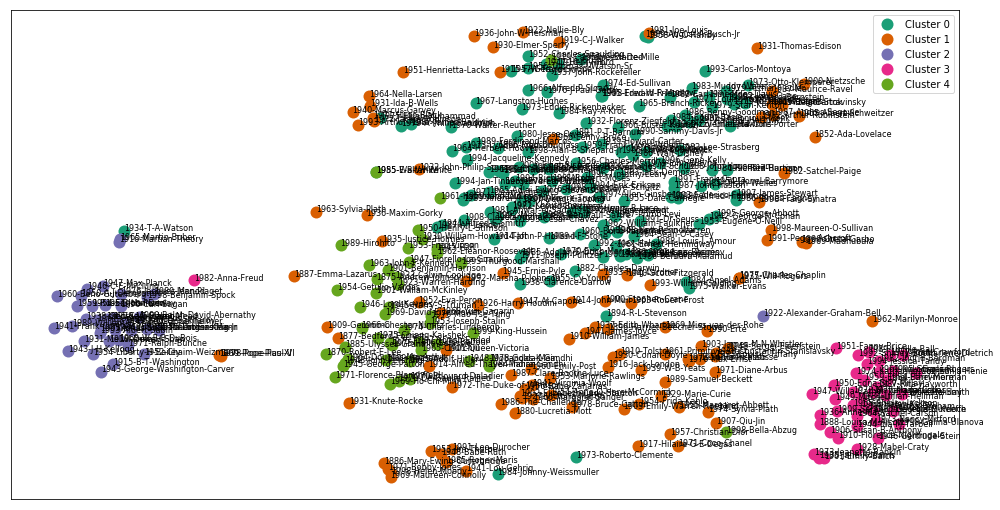

In [46]:
# set up plot
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

# iterate through groups to layer the plot
# note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return 
# the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False)
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  
    
plt.show() #show the plot
